# Nonlinear Transformations

We continue to build our regression repetoire with nonlinear transformations of both features and targets.

## What will we accomplish

In this notebook we will:
- Introduce nonlinear transformations
- See how linear regression accommodates fitting non-linear relationships.
    - We can use linear regression as long as our hypothesis space is spanned by a fixed collection of functions.
    - In other words, we need linearity in the *parameters* not the *features*.
- Show how to use sklearn's `PolynomialFeatures`

In [9]:
## import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

When we introduced linear regression we focused on a model of the form

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p + \epsilon
$$

In other words, our hypothesis space is $p+1$ dimensional space of functions, spanned by the constant function $1$ and the coordinate functions.

This can be easily generalized to a hypothesis space spanned by any finite collection of functions of the features:

$$
y = \beta_0 f_0(x_1,x_2,..., x_p) + \beta_1 f_1(x_1,x_2,..., x_p)  + \dots + \beta_m f_m(x_1,x_2,..., x_p) + \epsilon
$$

Given sample data $(\vec{x}_i, y_i)$ with $i = 1, 2, \dots, n$ we can assemble an  $n \times (m+1)$ design matrix $X$

$$
X = \begin{bmatrix} 
f_0(\vec{x}_1) & f_1(\vec{x}_1) & \dots & f_m(\vec{x}_1) \\
f_0(\vec{x}_2) & f_1(\vec{x}_2) & \dots & f_m(\vec{x}_2) \\
               &                & \vdots&                \\
f_0(\vec{x}_n) & f_1(\vec{x}_n) & \dots & f_m(\vec{x}_n) \\
\end{bmatrix}
$$

Then the OLS estimate of $\beta$ is given by the usual normal equations

$$
\hat{\beta} = (X^\top X)^{-1}X^\top y
$$

This is a (very slight) generalization of the setup we have seen thus far.

### Example

We introduce a new dataset sourced from [Kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data).

The original dataset was quite large:  it tracked the sales of $50$ different items in $10$ different store locations over $5$ years.  I trimmed it down to sales of one product at one particular grocery store over a $5$ year period.  These are **time series** data:  to do a really proper job of modeling we should use techniques which account for the ordered nature of the data.  With that important caveat, we will use this data to showcase regression using non-linear transformations of our features.

In [10]:
df_train = pd.read_csv('../../data/sales_train.csv', index_col=0, parse_dates=['date']) # 2013,2014,2015, 2016
df_test = pd.read_csv('../../data/sales_test.csv', index_col=0, parse_dates=['date']) # 2017
df_train.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


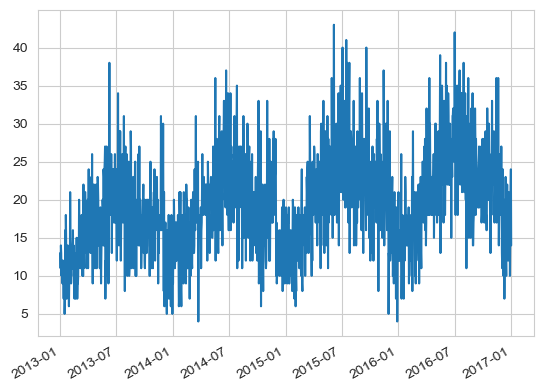

In [11]:
plt.plot(df_train.date, df_train.sales)
plt.gcf().autofmt_xdate()

plt.show()

There appears to be both an upward trend and yearly seasonality.  However, the seasonality is fairly complex.  We will choose a model of the form:

$$
f(t) = \beta_0 + \beta_1t + \sum_{j=0}^5 \phi_j \cos\left(\frac{(2+j)\pi}{365} t\right) + \psi_j\sin\left(\frac{(2+j)\pi}{365} t\right)
$$

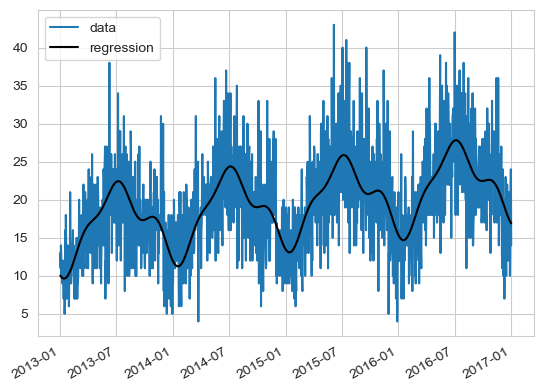

In [12]:
from sklearn.linear_model import LinearRegression

train_times = df_train.index.values
cosines = np.stack([np.cos((2+i)*np.pi*train_times/365) for i in range(5)]  , axis = 1)
sines = np.stack([np.sin((2+i)*np.pi*train_times/365) for i in range(5)]  , axis = 1)
train_features = np.concatenate([train_times.reshape(-1,1), cosines, sines], axis = 1)

lr = LinearRegression()
lr.fit(train_features,df_train.sales)
lr_train_preds = lr.predict(train_features)

plt.plot(df_train.date, df_train.sales, label = 'data')
plt.plot(df_train.date, lr_train_preds, 'k',label = 'regression')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

### Linear vs. Non-Linear Regression

We should be careful to distinguish linear regression (which we have studied so far) from non-linear regression. For example

$$f(x_1, x_2) = \beta_0 + \beta_1 x_1 + \beta_2 e^{x_2}$$

fits into our linear regression framework:  while it is not linear as a function of the features it is *linear as a function of the parameters*.  

We can fit it using regular linear regression with an appropriate design matrix.

On the other hand

$$f(x_1, x_2) = \beta_0 + \beta_1 x_1 + e^{\beta_2 x_2}$$

is **not** linear in its parameters.  We cannot find OLS minimizing $\beta_0, \beta_1, \beta_2$ using the normal equations.  In this particular case we could rewrite

$$\beta_0 + \beta_1 x_1 + e^{\beta_2 x_2} = \beta_0 + \beta_1 x_1 + e^{\beta_2} e^{x_2} = \beta_0 + \beta_1 x_1 + \gamma e^{x_2}  $$ 

by introducing a new parameter $\gamma = e^{\beta_2}$.

We can then treat this as a regular OLS problem.  This is an nice trick when it works, but it is not always possible to transform a non-linear regression problem into a linear regression problem in this way.



### `PolynomialFeatures`

`PolynomialFeatures` is an `sklearn` transformer object that takes in a 2D `numpy` array and returns a `numpy` array with columns corresponding to all the relevant polynomial transformations of the given `degree`, as illustrated by the image where `degree=2`:

<img src="lecture_4_assets/polyfeatures.png" width="65%"></img>

In [18]:
## import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

In [15]:
X = np.random.randint(low = -5, high = 5, size = (10,2))
X

array([[-3, -2],
       [-1,  4],
       [-1, -3],
       [-1,  2],
       [-4,  1],
       [-4,  4],
       [ 4, -5],
       [-2,  4],
       [ 0, -3],
       [-1, -4]])

In [21]:
## demonstrate PolynomialFeatures
## the first argument is the degree of the polynomial
## the interaction_only term says whether you just want interaction terms returned
## include_bias determines whether or not a column of 1s is returned
poly = PolynomialFeatures(degree = 3,
                            interaction_only = False,
                            include_bias = False)

poly.fit(X)

PolynomialFeatures(degree=3, include_bias=False)

In [23]:
# The transformed array.  This could be used as the design matrix in a regression.
poly.transform(X)

array([[  -3.,   -2.,    9.,    6.,    4.,  -27.,  -18.,  -12.,   -8.],
       [  -1.,    4.,    1.,   -4.,   16.,   -1.,    4.,  -16.,   64.],
       [  -1.,   -3.,    1.,    3.,    9.,   -1.,   -3.,   -9.,  -27.],
       [  -1.,    2.,    1.,   -2.,    4.,   -1.,    2.,   -4.,    8.],
       [  -4.,    1.,   16.,   -4.,    1.,  -64.,   16.,   -4.,    1.],
       [  -4.,    4.,   16.,  -16.,   16.,  -64.,   64.,  -64.,   64.],
       [   4.,   -5.,   16.,  -20.,   25.,   64.,  -80.,  100., -125.],
       [  -2.,    4.,    4.,   -8.,   16.,   -8.,   16.,  -32.,   64.],
       [   0.,   -3.,    0.,   -0.,    9.,    0.,   -0.,    0.,  -27.],
       [  -1.,   -4.,    1.,    4.,   16.,   -1.,   -4.,  -16.,  -64.]])

In [25]:
# Records the powers of the original features which are used in each column of the transformed array.
poly.powers_

array([[1, 0],
       [0, 1],
       [2, 0],
       [1, 1],
       [0, 2],
       [3, 0],
       [2, 1],
       [1, 2],
       [0, 3]])

--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.